## Matanzas_CRF_to_roughness
* Read in the results of the CRF pixel classification
* Use look-up table to assign roughness
* Interpolate onto model grid

In [1]:
import numpy as np
import pandas as pd
import rasterio # rasterio and OGR don't mix...see rasterio docs
import matplotlib.pyplot as plt
import xarray as xr
import scipy.io as sio
import scipy.signal
from pyproj import Proj, transform
from scipy import interpolate

%matplotlib inline

### Load the image that was classified
This is only needed for the projection and the coordinates.

In [12]:
fn = r'..\naip.tif'
da = xr.open_rasterio(fn)
da

<xarray.DataArray (band: 3, y: 9539, x: 16355)>
[468031035 values with dtype=uint8]
Coordinates:
  * band     (band) int32 1 2 3
  * y        (y) float64 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 29.7 ...
  * x        (x) float64 -81.24 -81.24 -81.24 -81.24 -81.24 -81.24 -81.24 ...
Attributes:
    transform:   (3.144103494418427e-06, 0.0, -81.24381501674641, 0.0, -3.144...
    crs:         +init=epsg:4269
    res:         (3.144103494418427e-06, 3.144103494418295e-06)
    is_tiled:    0
    nodatavals:  (nan, nan, nan)

### Load the output from the CRF classification of the same image
This was generated by ```int_seg_crf_v1.py``` with user input.

In [4]:
m = sio.loadmat(r'..\naip_mres.mat')

In [5]:
np.shape(m['class'])

(9539, 16355)

### Make a dict to convert CRF class to Manning's n.

This is an approximation of Mattocks & Forbes (2008) Table 3.

See also https://github.com/csherwood-usgs/NLCD_to_Roughness/blob/master/NLCD_to_Roughness.ipynb

```
classes = {'sand':'d', 'wetland veg':'g', 'water':'y', 'dune grass':'v',\
   'woody vegetation':'n','structure':'q','road':'r','surf':'s'}
```

In [7]:
# The CRF program crashed while trying to write the output, but naip_mres.mat still included the classes.
# The class labels were not saved...recreate them:
labels = np.array(['sand            ', 'wetland veg     ', 'water           ',\
       'dune grass      ', 'woody vegetation',             'structure       ',\
       'road            ', 'surf            '], 
      dtype='<U16' )
labels

array(['sand            ', 'wetland veg     ', 'water           ',
       'dune grass      ', 'woody vegetation', 'structure       ',
       'road            ', 'surf            '], 
      dtype='<U16')

In [8]:
# These roughness assignments are up for some debate. In particular, MF2008 assign sand = 0.09, but I chose 0.02 (same as water)
# I also put structure at 0.05, because it is not well classified, and I did not want random big roughness elements.
n = {0: 0.02, 1: 0.045, 2: .02, 3: 0.034, 4: 0.05, 5: 0.1, 6: 0.09, 7: 0.02}


In [9]:
# initialize a float array with same shape as class array
nmap = 0.0*np.ones_like(m['class'])
(ni,nj)=np.shape(nmap)
print('Shapes of new np array and DataArray: ',np.shape(m['class']),np.shape(nmap))
print('Print number of rows, columns: ',ni,nj)

# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[m['class'][i,j]]
print('\nRoughness values:')
nmap

Shapes of new np array and DataArray:  (9539, 16355) (9539, 16355)
Print number of rows, columns:  9539 16355

Roughness values:


array([[ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.045,  0.045,  0.045, ...,  0.02 ,  0.02 ,  0.02 ],
       ..., 
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ],
       [ 0.05 ,  0.05 ,  0.05 , ...,  0.02 ,  0.02 ,  0.02 ]])

### Quick plot of the roughness map

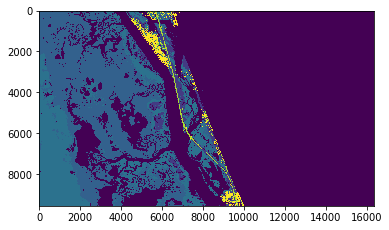

In [18]:
plt.imshow(nmap)

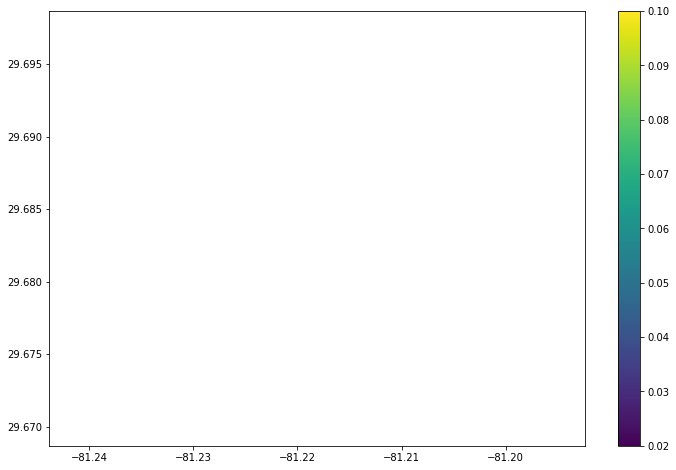

In [19]:
plt.figure(figsize=(12,8))
plt.pcolormesh(da['x'].values, da['y'].values, nmap, edgecolors='none',shading='flat')
plt.colorbar()

### Export utm coords, classes, and roughness values to Matlab file

In [15]:
sio.savemat('Matanzas_nmap.mat',{'lon': da['x'].values, 'lat': da['y'].values, 'n': nmap, 'class': m['class']},do_compression=True)

### Interpolate onto Delft grid

* Probably want to smooth the roughness grid first
* Might have a problem when model grid extends beyond CRF grid
* And need to apply some logic to clean up a few pixels.

In [9]:
# smooth with 2D running median
nmapf = scipy.signal.medfilt2d(nmap, kernel_size=5)

In [10]:
# Import COAWST grid.
dsc = xr.open_dataset('FI_breach_grd50.nc')

# Define the transformation
llProj = Proj(init='epsg:4326') # WGS84 lat/lon
utmProj = Proj(da.crs)

ec,nc = transform(llProj,utmProj,dsc.lon_rho.values,dsc.lat_rho.values)

In [11]:
# Both of these whine about the fact that y decreases, rather than increases...so flip y and nmap
y = np.flipud(da['y'].values)
nmapf = np.flipud(nmapf)
f=interpolate.RegularGridInterpolator((y,da['x'].values), nmapf, method='nearest')

In [12]:
# The interpolation will crash trying to fill model grid points that are outside the domain of the roughness map.
# I need to expand the domain of the roughness map for the COAWST grid. But here is how I would do it:
cnmapi = f((nc,ec))

ValueError: One of the requested xi is out of bounds in dimension 0